# **Procesamiento de imágenes digitales (Transformaciones de vecindario)**

## **Contenido**

[**1. Convolution**](#tema1)

[**2. Gaussian Filtering**](#tema2)

In [1]:
!pip install numpy
!pip install opencv-python
!pip install matplotlib

# Librerias necesarias para la sesión

In [2]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

# Convolution

Convolución 1D.

In [3]:
def zero_pad(X, pad):
    X_pad = np.pad(X, pad, 'constant', constant_values=0)
    return X_pad

def conv_step(x, W):
    return np.sum(np.multiply(x, W))

def conv(s, k):
    diff = abs(len(s) - len(k) - 1)
    slide = len(k)
    # flip kernel
    k = k [::-1]
    Z = np.zeros(shape=len(s)-diff)
    for i in range(Z.shape[0]):
        Z[i] = conv_step(s[i:i+slide], k)
    return Z

In [4]:
# Probando convolución 1D
f = [1, 2, 3, 4]
h = [0.5, 0, -0.5]
print(np.convolve(f, h, 'same'))  # [ 1.   1.   1.  -1.5]
print(conv(zero_pad(f,1), h))  # [ 1.   1.   1.  -1.5]

[ 1.   1.   1.  -1.5]
[ 1.   1.   1.  -1.5]


In [5]:
zero_pad(f,1)

array([0, 1, 2, 3, 4, 0])

In [6]:
print(np.convolve(f, h))

[ 0.5  1.   1.   1.  -1.5 -2. ]


# Reto: Implementar la convolución 2D "a mano" y comparar contra la función de OpenCV

Definimos la función para hacer la convolución 2D.

In [7]:
def sampler(source, pixel_core, padding_core):
    lower_lim = pixel_core[0] - padding_core
    upper_lim = pixel_core[0] + padding_core
    left_lim = pixel_core[1] - padding_core
    right_lim = pixel_core[1] + padding_core

    return source[lower_lim:(upper_lim + 1), left_lim:(right_lim + 1)]

def conv_step2D(source, kernel):
    return np.dot(source.flatten(), kernel.flatten())

def convolve(image, kernel):
    output = np.ones(image.shape)
    
    kernel_core = [(kernel.shape[0] - 1) / 2, (kernel.shape[1] - 1) / 2]
    padding = int(kernel_core[0] - 0)
    
    pad_image = np.pad(image, padding, mode = "reflect")

    kernel_weight = np.abs(np.sum(kernel))
    if kernel_weight != 0:
        kernel = kernel / kernel_weight

    for row in range(image.shape[0]):
        for column in range(image.shape[1]):
            core = [row + padding, column + padding]
            window = sampler(pad_image, core, padding)
            output[row, column] = conv_step2D(window, kernel)

    output = np.clip(output, 0, 255)
    return output.astype("uint8")

Definimos algunos *kernels* comunes para operar en las imágenes y probar la efectividad del método.

In [8]:
# box kernels
smallBlur = np.ones((7, 7), dtype="float") * (1.0 / (7 * 7))
largeBlur = np.ones((21, 21), dtype="float") * (1.0 / (21 * 21))

# Sobel kernel horizontal
sobelX = np.array((
	[-1, 0, 1],
	[-2, 0, 2],
	[-1, 0, 1]), dtype="int")

# Sobel kernel vertical
sobelY = np.array((
	[-1, -2, -1],
	[0, 0, 0],
	[1, 2, 1]), dtype="int")

# Laplacian kernel
laplacian = np.array((
	[0, 1, 0],
	[1, -4, 1],
	[0, 1, 0]), dtype="int")

# Laplacian kernel con diagonales
laplacianDiag = np.array((
	[1, 1, 1],
	[1, -8, 1],
	[1, 1, 1]), dtype="int")

# sharpening kernel
sharpen = np.array((
	[0, -1, 0],
	[-1, 5, -1],
	[0, -1, 0]), dtype="int")

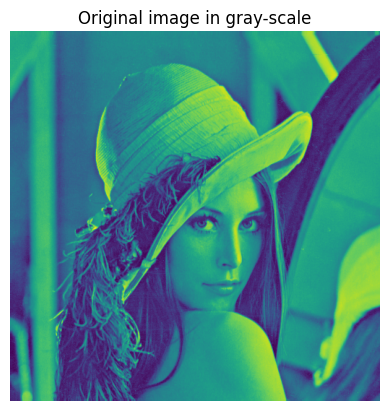

In [9]:
# load the input image and convert it to grayscale
image = cv.imread('../resources/images/convolution/Lena512x512.png')
gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

plt.imshow(gray)
plt.title('Original image in gray-scale')
plt.axis('off')
plt.show()

Aplicamos la primera primera prueba con el **large blur**.

In [10]:
manual_large_blur = convolve(gray, largeBlur)
opencv_large_blur = cv.filter2D(gray, -1, largeBlur)

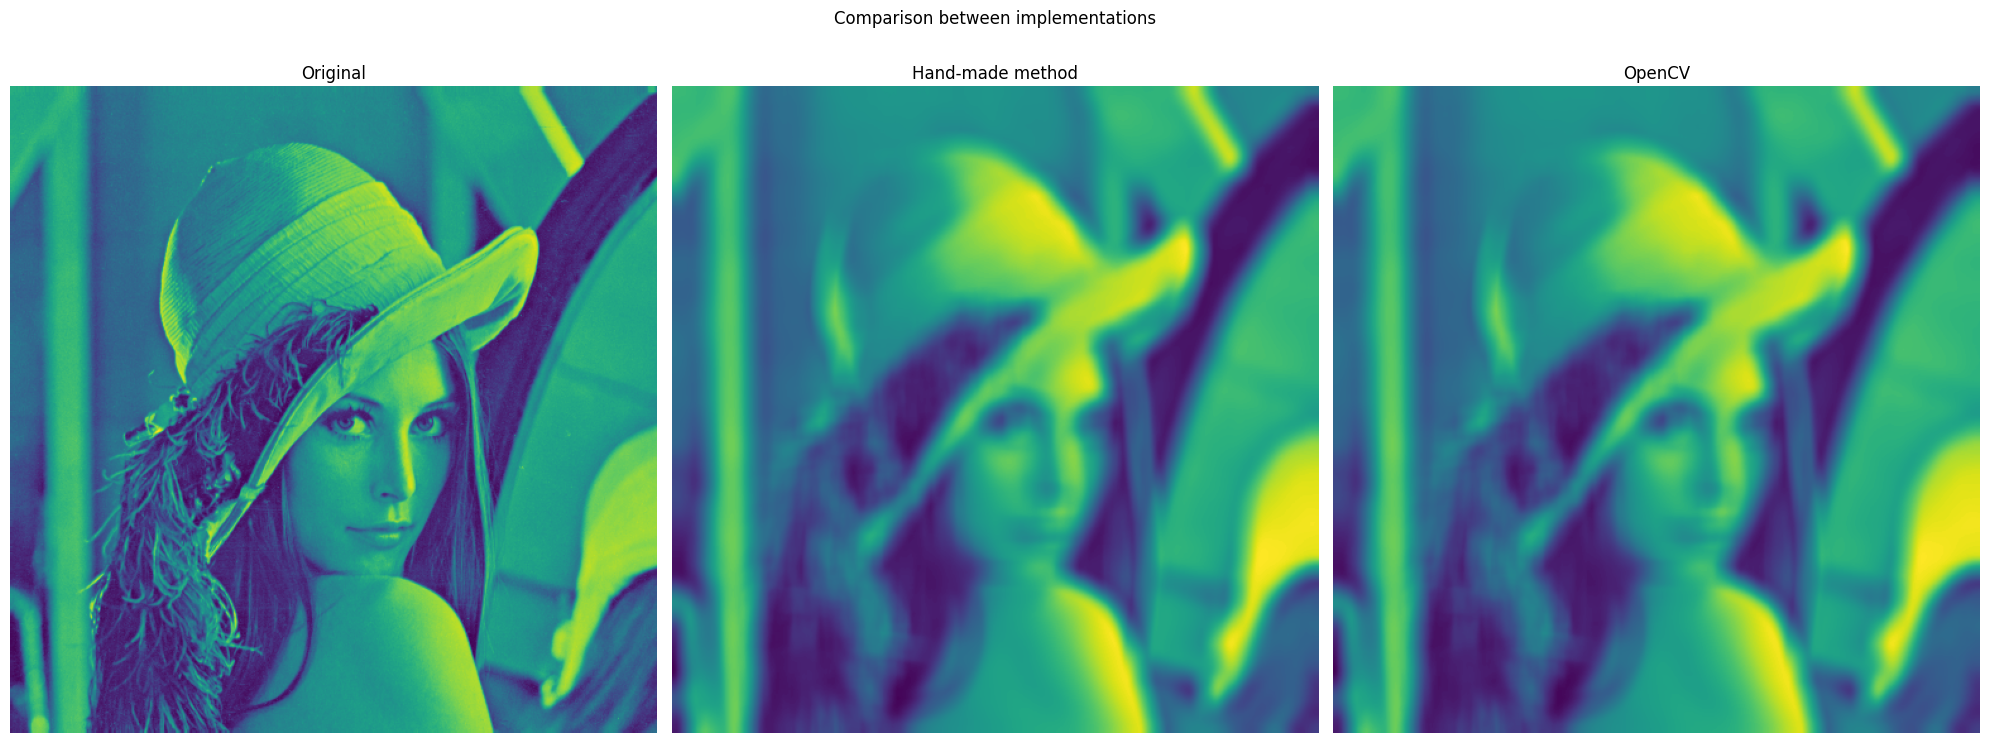

In [11]:
plt.figure(figsize = (20, 8))
plt.subplot(131)
plt.imshow(gray)
plt.title('Original')
plt.axis('off')
plt.subplot(132)
plt.imshow(manual_large_blur)
plt.title('Hand-made method')
plt.axis('off')
plt.subplot(133)
plt.imshow(opencv_large_blur)
plt.title('OpenCV')
plt.axis('off')

plt.suptitle('Comparison between implementations')
plt.tight_layout()
plt.show()

# Prueba con los otros filtros y confirma que quedó bien implementado tu método

Se aplica el filtro *laplaciano*.

In [12]:
manual_laplacian = convolve(gray, laplacian)
opencv_laplacian = cv.filter2D(gray, -1, laplacian)

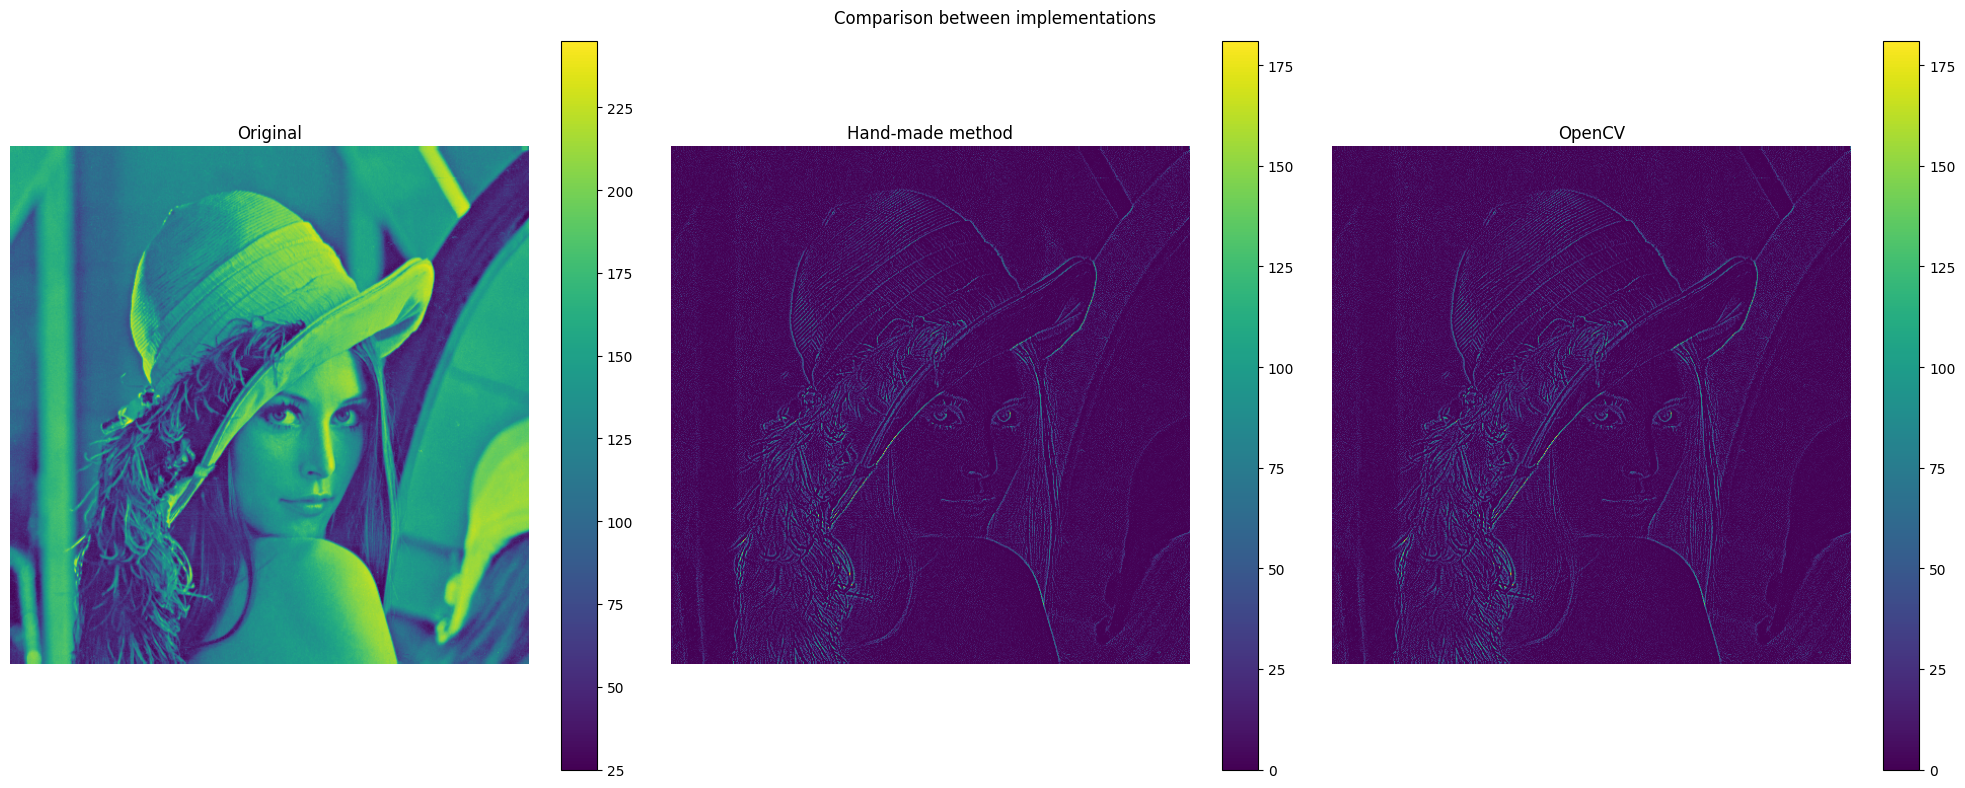

In [13]:
plt.figure(figsize = (20, 8))
plt.subplot(131)
plt.imshow(gray)
plt.title('Original')
plt.axis('off')
plt.colorbar()
plt.subplot(132)
plt.imshow(manual_laplacian)
plt.title('Hand-made method')
plt.axis('off')
plt.colorbar()
plt.subplot(133)
plt.imshow(opencv_laplacian)
plt.title('OpenCV')
plt.axis('off')
plt.colorbar()

plt.suptitle('Comparison between implementations')
plt.tight_layout()
plt.show()

# Gaussian Filtering

In [14]:
def gaussian_kernel(sample_range=5, sigma=1):
    """\
    creates gaussian kernel with side length `l` and a sigma of `sig`
    """
    ax = np.linspace(-(sample_range - 1) / 2., (sample_range - 1) / 2., sample_range)
    xx, yy = np.meshgrid(ax, ax)
    gauss = np.exp(-(xx ** 2 + yy ** 2) / (2 * sigma **2))
    return gauss / np.sum(gauss)

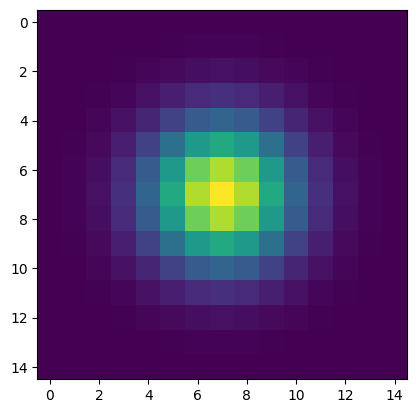

In [15]:
gauss_kernel = gaussian_kernel(15, 2)
plt.imshow(gauss_kernel)
plt.show()

In [16]:
manual_gaussian = convolve(gray, gauss_kernel)
opencv_gaussian  = cv.filter2D(gray, -1, gauss_kernel)

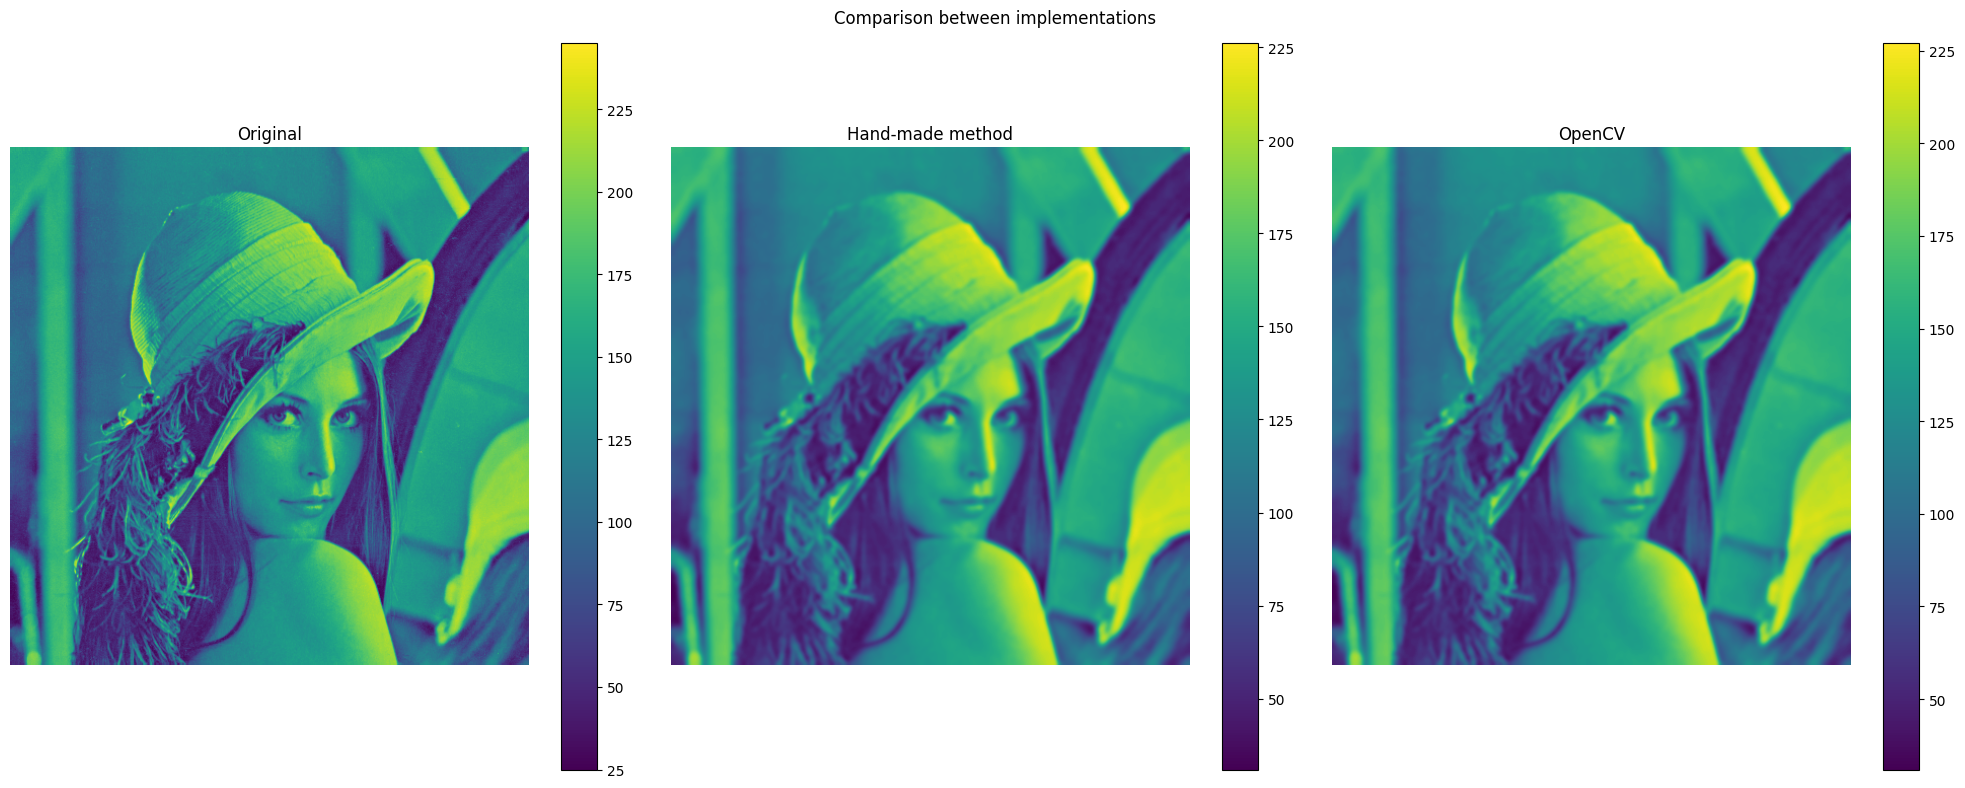

In [17]:
plt.figure(figsize = (20, 8))
plt.subplot(131)
plt.imshow(gray)
plt.title('Original')
plt.axis('off')
plt.colorbar()
plt.subplot(132)
plt.imshow(manual_gaussian)
plt.title('Hand-made method')
plt.axis('off')
plt.colorbar()
plt.subplot(133)
plt.imshow(opencv_gaussian)
plt.title('OpenCV')
plt.axis('off')
plt.colorbar()

plt.suptitle('Comparison between implementations')
plt.tight_layout()
plt.show()

## Agregando ruido blanco

Se genera un ruido blanco para afectar la imagen original, con una desviación estándar $\sigma = 30$.

In [18]:
NOISE_STD = 30

noise = np.random.normal(scale = NOISE_STD, size = gray.shape)
noisy_image = (gray + noise).astype('uint8')

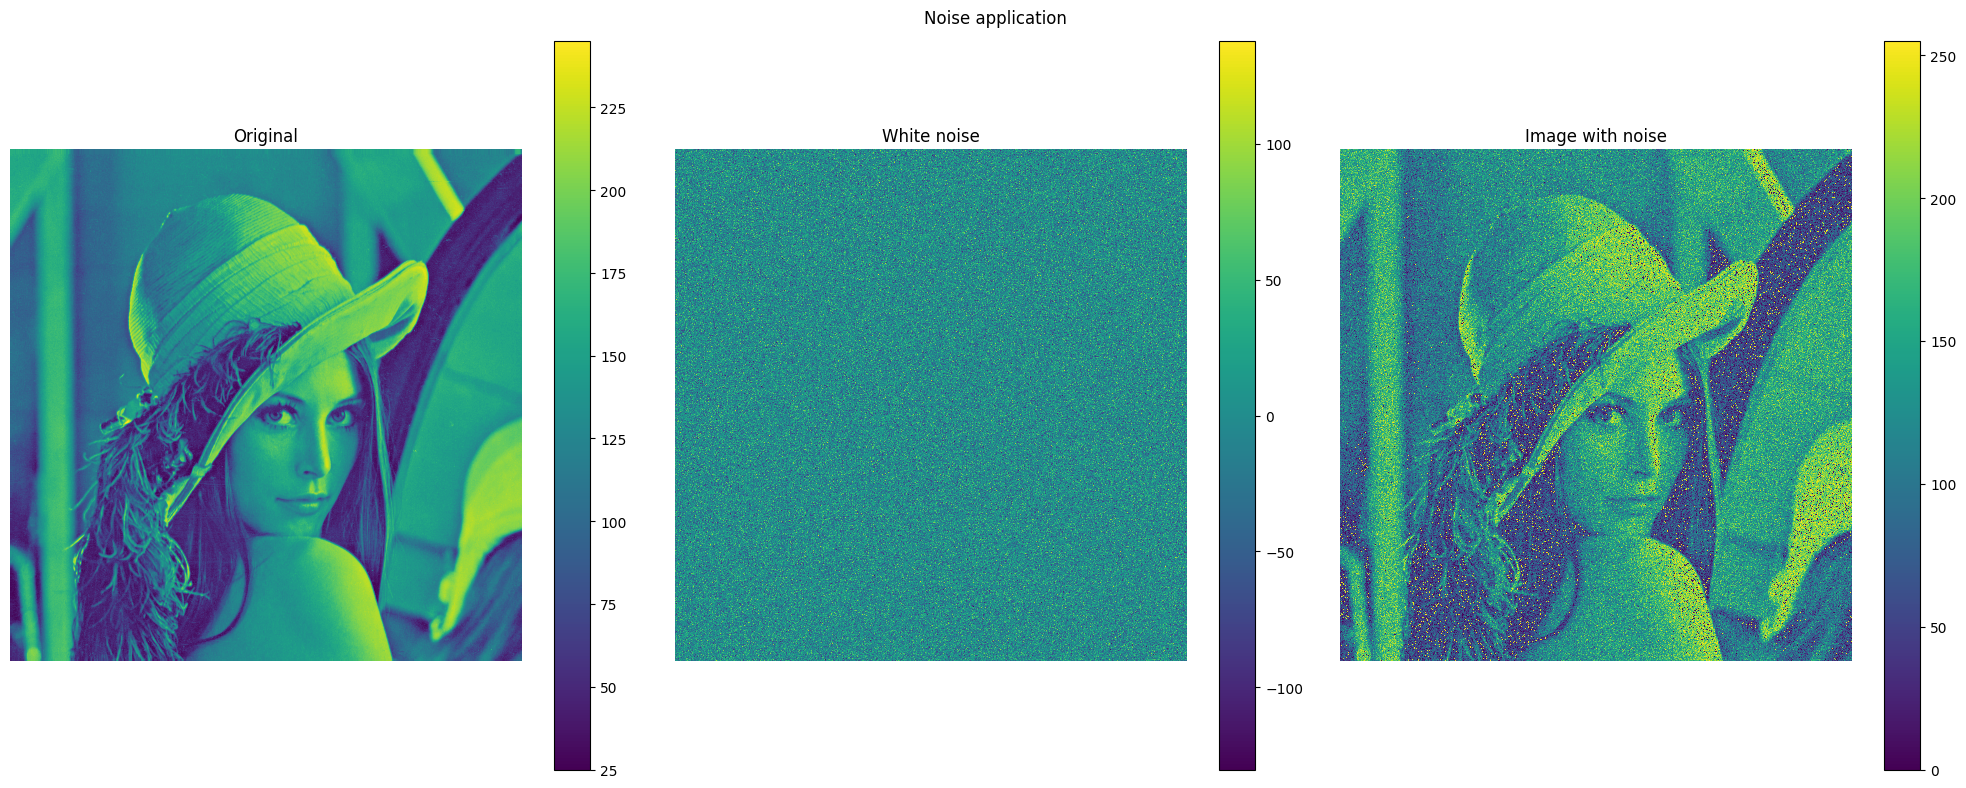

In [19]:
plt.figure(figsize = (20, 8))
plt.subplot(131)
plt.imshow(gray)
plt.title('Original')
plt.axis('off')
plt.colorbar()
plt.subplot(132)
plt.imshow(noise)
plt.title('White noise')
plt.axis('off')
plt.colorbar()
plt.subplot(133)
plt.imshow(noisy_image)
plt.title('Image with noise')
plt.axis('off')
plt.colorbar()

plt.suptitle('Noise application')
plt.tight_layout()
plt.show()

Filtrando el ruido usando filtro promedio

In [20]:
manual_gaussian_noisy = convolve(noisy_image, gauss_kernel)
opencv_gaussian_noisy = cv.filter2D(noisy_image, -1, gauss_kernel)

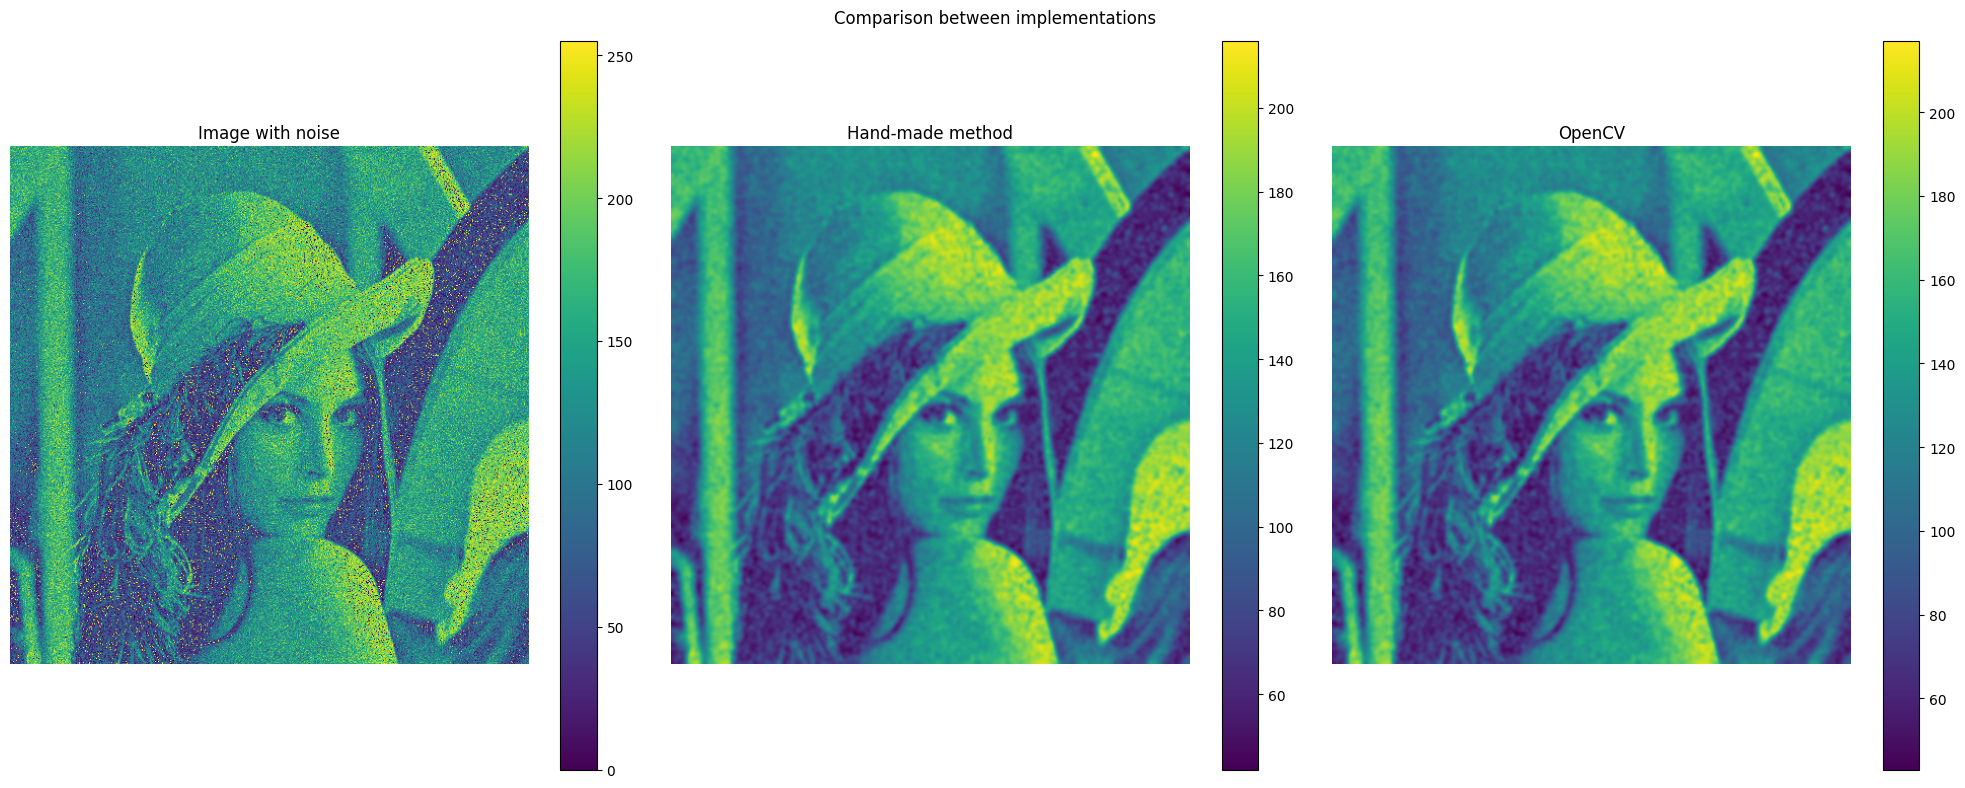

In [21]:
plt.figure(figsize = (20, 8))
plt.subplot(131)
plt.imshow(noisy_image)
plt.title('Image with noise')
plt.axis('off')
plt.colorbar()
plt.subplot(132)
plt.imshow(manual_gaussian_noisy)
plt.title('Hand-made method')
plt.axis('off')
plt.colorbar()
plt.subplot(133)
plt.imshow(opencv_gaussian_noisy)
plt.title('OpenCV')
plt.axis('off')
plt.colorbar()

plt.suptitle('Comparison between implementations')
plt.tight_layout()
plt.show()